In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import folium
import pandas as pd
import pypsa
from pypsa.linopt import get_var, linexpr, define_constraints
from geopy import distance
from geopy.geocoders import Nominatim

%matplotlib inline

In [2]:
def get_network(years_select):
    years_simulate = years_select
    network = pypsa.Network(get_electrical_data(years_simulate))

    return network


def get_electrical_data(years_elect):
    if years_elect == '2030':
        return "C:/Users/work/pypsa_thesis/data/electrical/2030"
    elif years_elect == '2040':
        return "C:/Users/work/pypsa_thesis/data/electrical/2040"
    elif years_elect == '2050':
        return "C:/Users/work/pypsa_thesis/data/electrical/2050"


def calculate_annuity(n, r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20, 0.05) * 20 = 1.6"""

    if isinstance(r, pd.Series):
        return pd.Series(1 / n, index=r.index).where(r == 0, r / (1. - 1. / (1. + r) ** n))
    elif r > 0:
        return r / (1. - 1. / (1. + r) ** n)
    else:
        return 1 / n


def get_techno_econ_data(n_years, years_data, discount_rate, network):
    network = network
    discount_rate = discount_rate
    n_years = n_years

    if years_data == '2030':
        load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/techno_economic/pypsa_costs_2030.csv")
        df_load_data = pd.DataFrame(load_data)
    elif years_data == '2040':
        load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/techno_economic/pypsa_costs_2040.csv")
        df_load_data = pd.DataFrame(load_data)
    elif years_data == '2050':
        load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/techno_economic/pypsa_costs_2050.csv")
        df_load_data = pd.DataFrame(load_data)

    # correct units to MW
    df_load_data.loc[df_load_data.unit.str.contains("/kW"), "value"] *= 1e3

    df_tech_costs = pd.DataFrame(columns=['carriers', 'capital_costs', 'marginal_costs', 'efficiency', 'co2_emissions'])
    df_tech_costs['carriers'] = list(network.carriers.index)
    df_tech_costs.set_index('carriers', inplace=True)

    for carrier_x in list(df_tech_costs.index):
        if carrier_x != 'H2' or carrier_x != 'Water_Reservoir':
            if carrier_x in list(df_load_data['technology']):
                if carrier_x not in ('Solar', 'Wind_Offshore', 'Wind_Onshore', 'H2_(g)_pipeline'):
                    df_cap_cost = pd.DataFrame(df_load_data[df_load_data['technology'] == carrier_x])
                    lifetime = float(df_cap_cost[df_cap_cost['parameter'] == 'lifetime']['value'])
                    FOM = float(df_cap_cost[df_cap_cost['parameter'] == 'FOM']['value'])
                    investment = float(df_cap_cost[df_cap_cost['parameter'] == 'investment']['value'])
                    efficiency_x = float(df_cap_cost[df_cap_cost['parameter'] == 'efficiency']['value'])
                    df_tech_costs.at[carrier_x, 'capital_costs'] = round(((calculate_annuity(lifetime, discount_rate) +
                                                                           FOM / 100.) *
                                                                          investment * n_years), 2)
                    df_tech_costs.at[carrier_x, 'efficiency'] = efficiency_x
                else:
                    df_cap_cost = pd.DataFrame(df_load_data[df_load_data['technology'] == carrier_x])
                    lifetime = float(df_cap_cost[df_cap_cost['parameter'] == 'lifetime']['value'])
                    FOM = float(df_cap_cost[df_cap_cost['parameter'] == 'FOM']['value'])
                    investment = float(df_cap_cost[df_cap_cost['parameter'] == 'investment']['value'])
                    df_tech_costs.at[carrier_x, 'capital_costs'] = round(((calculate_annuity(lifetime, discount_rate) +
                                                                           FOM / 100.) *
                                                                          investment * n_years), 2)
                    df_tech_costs.at[carrier_x, 'efficiency'] = 1.0

    for carrier_y in list(df_tech_costs.index):
        if carrier_y in ('Biomass', 'CCGT', 'Coal', 'Lignite', 'Oil'):
            if carrier_y == 'CCGT':
                df_mar_cost = pd.DataFrame(df_load_data[df_load_data['technology'] == carrier_y])
                VOM = float(df_mar_cost[df_mar_cost['parameter'] == 'VOM']['value'])
                fuel = float(
                    df_load_data[(df_load_data['parameter'] == 'fuel') & (df_load_data['technology'] == 'gas')][
                        'value'])
                efficiency_y = float(df_mar_cost[df_mar_cost['parameter'] == 'efficiency']['value'])
                df_tech_costs.at[carrier_y, 'marginal_costs'] = round(VOM + fuel / efficiency_y, 2)
            elif carrier_y == 'Biomass':
                fuel = float(
                    df_load_data[(df_load_data['parameter'] == 'fuel') & (df_load_data['technology'] == carrier_y)][
                        'value'])
                efficiency_y = float(df_load_data[(df_load_data['parameter'] == 'efficiency') & (
                            df_load_data['technology'] == carrier_y)]['value'])
                df_tech_costs.at[carrier_y, 'marginal_costs'] = round(fuel / efficiency_y, 2)
            else:
                df_mar_cost = pd.DataFrame(df_load_data[df_load_data['technology'] == carrier_y])
                VOM = float(df_mar_cost[df_mar_cost['parameter'] == 'VOM']['value'])
                fuel = float(df_mar_cost[df_mar_cost['parameter'] == 'fuel']['value'])
                efficiency_y = float(df_mar_cost[df_mar_cost['parameter'] == 'efficiency']['value'])
                df_tech_costs.at[carrier_y, 'marginal_costs'] = round(VOM + fuel / efficiency_y, 2)

    for carrier_z in list(df_tech_costs.index):
        if carrier_z in ('OCGT', 'CCGT', 'Coal', 'Lignite', 'Oil'):
            if carrier_z == 'OCGT' or carrier_z == 'CCGT':
                co2_intensity = float(df_load_data[(df_load_data['technology'] == 'Gas') &
                                                   (df_load_data['parameter'] == 'CO2 intensity')]['value'])
                df_tech_costs.at['{}'.format(carrier_z), 'co2_emissions'] = co2_intensity
            else:
                co2_intensity = float(df_load_data[(df_load_data['technology'] == '{}'.format(carrier_z)) &
                                                   (df_load_data['parameter'] == 'CO2 intensity')]['value'])
                df_tech_costs.at['{}'.format(carrier_z), 'co2_emissions'] = co2_intensity

    df_tech_costs.fillna(0, inplace=True)

    return df_tech_costs


def get_hydrogen_data(scenario_h2, years_h2, h2_config, network):
    network = network
    if scenario_h2 == 'TN-H2-G':
        if years_h2 == '2030':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2030.csv",
                                    index_col=0)

        elif years_h2 == '2040':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2040.csv",
                                    index_col=0)

        elif years_h2 == '2050':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2050.csv",
                                    index_col=0)

    elif scenario_h2 == 'TN-PtG-PtL':
        if years_h2 == '2030':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2030.csv",
                                    index_col=0)

        elif years_h2 == '2040':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2040.csv",
                                    index_col=0)

        elif years_h2 == '2050':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2050.csv",
                                    index_col=0)

    elif scenario_h2 == 'TN-Strom':
        if years_h2 == '2030':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2030.csv",
                                    index_col=0)

        elif years_h2 == '2040':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2040.csv",
                                    index_col=0)

        elif years_h2 == '2050':
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2050.csv",
                                    index_col=0)

    df_h2_demand = pd.DataFrame(load_data)
    df_h2_demand.index.names = ['location_name']
    df_h2_demand.reset_index(inplace=True)
    df_h2_demand.dropna(subset=['location_name'], inplace=True)
    x_coor = []
    y_coor = []

    for loc_count in range(len(df_h2_demand['location_name'])):
        geolocator = Nominatim(user_agent="locate_h2_demand")
        locate_h2_demand = geolocator.geocode(df_h2_demand['location_name'][loc_count].split(',')[0])
        x_coor.append(locate_h2_demand.longitude)
        y_coor.append(locate_h2_demand.latitude)

    df_h2_demand['x'] = x_coor
    df_h2_demand['y'] = y_coor
    df_ac_loads_h2_loads_dist = pd.DataFrame(index=network.loads.index, columns=df_h2_demand['location_name'])

    for city_count_x in range(len(network.loads.index)):
        for city_count_y in range(len(df_h2_demand['location_name'])):
            if network.loads.index[city_count_x] != df_h2_demand['location_name'][city_count_y]:
                city_1 = (network.loads['y'][city_count_x], network.loads['x'][city_count_x])
                city_2 = (df_h2_demand['y'][city_count_y], df_h2_demand['x'][city_count_y])
                dist_city1_city2 = distance.distance(city_1, city_2).km
                df_ac_loads_h2_loads_dist.at[
                    network.loads.index[city_count_x], df_h2_demand['location_name'][city_count_y]] = dist_city1_city2

    ac_loads_h2_links = []

    for column_count_x in df_ac_loads_h2_loads_dist.columns:
        for distance_count_x in range(len(df_ac_loads_h2_loads_dist[column_count_x])):
            if df_ac_loads_h2_loads_dist[column_count_x][distance_count_x] == \
                    df_ac_loads_h2_loads_dist[column_count_x].min():
                ac_loads_h2_links.append(df_ac_loads_h2_loads_dist.index[distance_count_x])

    ac_loads_h2_links = list(dict.fromkeys(ac_loads_h2_links))

    df_h2_buses_load = pd.DataFrame(index=ac_loads_h2_links, columns={'h2_load': [], 'x': [], 'y': []})

    for buses_count in range(len(network.buses.index)):
        for h2_buses_count in range(len(df_h2_buses_load.index)):
            if network.buses.index[buses_count] == df_h2_buses_load.index[h2_buses_count]:
                df_h2_buses_load['x'][h2_buses_count] = network.buses['x'][buses_count]
                df_h2_buses_load['y'][h2_buses_count] = network.buses['y'][buses_count]

    df_h2_buses_load.fillna(0, inplace=True)

    for column_count_y, i_count_y in zip(df_ac_loads_h2_loads_dist.columns, range(len(df_h2_demand['location_name']))):
        for distance_count_y in range(len(df_ac_loads_h2_loads_dist[column_count_y])):
            if df_ac_loads_h2_loads_dist[column_count_y][distance_count_y] == \
                    df_ac_loads_h2_loads_dist[column_count_y].min():
                h2_load_value = df_h2_demand[df_h2_demand['location_name'] == column_count_y]['demand_value'][
                                    i_count_y] * 1e6  # in MWh
                h2_demand_loc = df_ac_loads_h2_loads_dist.index[distance_count_y]
                if df_h2_buses_load.at[h2_demand_loc, 'h2_load'] == 0:
                    df_h2_buses_load.at[h2_demand_loc, 'h2_load'] = h2_load_value
                else:
                    df_h2_buses_load.at[h2_demand_loc, 'h2_load'] = df_h2_buses_load.at[h2_demand_loc, 'h2_load'] + \
                                                                    h2_load_value

    df_h2_pipelines_dist = pd.DataFrame(index=ac_loads_h2_links, columns=ac_loads_h2_links)

    for column_count_z in range(len(list(df_h2_pipelines_dist.index))):
        for row_count_z in range(len(list(df_h2_pipelines_dist.columns))):
            if df_h2_pipelines_dist.index[column_count_z] != df_h2_pipelines_dist.columns[row_count_z]:
                loc_1 = (df_h2_buses_load['y'][column_count_z], df_h2_buses_load['x'][column_count_z])
                loc_2 = (df_h2_buses_load['y'][row_count_z], df_h2_buses_load['x'][row_count_z])
                dist_loc_1_loc_2 = distance.distance(loc_1, loc_2).km
                df_h2_pipelines_dist.at[
                    df_h2_pipelines_dist.columns[row_count_z], df_h2_pipelines_dist.index[column_count_z]] = \
                    dist_loc_1_loc_2

    if h2_config == 'short':

        h2_pipe_row_list = []
        h2_bus_0_list = []
        h2_bus_1_list = []
        bus_0_list = []
        bus_1_list = []
        distance_km_list = []

        for city_count_p in list(df_h2_pipelines_dist.columns):
            for city_count_q in range(len(list(df_h2_pipelines_dist.index))):
                if df_h2_pipelines_dist[city_count_p][city_count_q] == \
                        df_h2_pipelines_dist[city_count_p].min():
                    h2_pipe_row_list.append(
                        '{}_{}_h2_pipe'.format(city_count_p, df_h2_pipelines_dist.index[city_count_q]))
                    h2_bus_0_list.append('{}_H2_Bus'.format(city_count_p))
                    h2_bus_1_list.append('{}_H2_Bus'.format(df_h2_pipelines_dist.index[city_count_q]))
                    bus_0_list.append(city_count_p)
                    bus_1_list.append(df_h2_pipelines_dist.index[city_count_q])
                    distance_km_list.append(df_h2_pipelines_dist[city_count_p].min())

        df_h2_pipelines = pd.DataFrame(index=h2_pipe_row_list)
        df_h2_pipelines.index.names = ['H2_pipelines']

        df_h2_pipelines['bus_0'] = h2_bus_0_list
        df_h2_pipelines['bus_1'] = h2_bus_1_list
        df_h2_pipelines['distance_km'] = distance_km_list

        df_h2_pipelines.drop_duplicates(subset=['distance_km'], inplace=True)

    elif h2_config == 'all':

        h2_pipe_row_list = []
        h2_bus_0_list = []
        h2_bus_1_list = []
        bus_0_list = []
        bus_1_list = []
        distance_km_list = []

        for city_count_r in list(df_h2_pipelines_dist.columns):
            for city_count_s, i_count_s in zip(list(df_h2_pipelines_dist.index),
                                               range(len(list(df_h2_pipelines_dist.index)))):
                if city_count_r != city_count_s:
                    h2_pipe_row_list.append(
                        '{}_{}_h2_pipe'.format(city_count_r, city_count_s))
                    h2_bus_0_list.append('{}_H2_Bus'.format(city_count_r))
                    h2_bus_1_list.append('{}_H2_Bus'.format(city_count_s))
                    bus_0_list.append(city_count_r)
                    bus_1_list.append(city_count_s)
                    distance_km_list.append(df_h2_pipelines_dist[city_count_r][i_count_s])

        df_h2_pipelines = pd.DataFrame(index=h2_pipe_row_list)
        df_h2_pipelines.index.names = ['H2_pipelines']

        df_h2_pipelines['bus_0'] = h2_bus_0_list
        df_h2_pipelines['bus_1'] = h2_bus_1_list
        df_h2_pipelines['distance_km'] = distance_km_list

        df_h2_pipelines.drop_duplicates(subset=['distance_km'], inplace=True)

    elif h2_config == 'short_fnb_2030':

        h2_pipe_row_list = []
        h2_bus_0_list = []
        h2_bus_1_list = []
        bus_0_list = []
        bus_1_list = []
        distance_km_list = []

        for city_count_a in list(df_h2_pipelines_dist.columns):
            for city_count_b in range(len(list(df_h2_pipelines_dist.index))):
                if df_h2_pipelines_dist[city_count_a][city_count_b] == \
                        df_h2_pipelines_dist[city_count_a].min():
                    h2_pipe_row_list.append(
                        '{}_{}_h2_pipe'.format(city_count_a, df_h2_pipelines_dist.index[city_count_b]))
                    h2_bus_0_list.append('{}_H2_Bus'.format(city_count_a))
                    h2_bus_1_list.append('{}_H2_Bus'.format(df_h2_pipelines_dist.index[city_count_b]))
                    bus_0_list.append(city_count_a)
                    bus_1_list.append(df_h2_pipelines_dist.index[city_count_b])
                    distance_km_list.append(df_h2_pipelines_dist[city_count_a].min())

        if scenario_h2 == 'TN-H2-G':
            # below connections currently only for BW, only applicable for TN-H2-G scenario
            fnb_2030_add = [['Eichstetten_110kV', 'Lorrach_110kV'],
                            ['KarlsruheWest_110kV', 'HeidelburgSud_110kV'],
                            ['Grossgartach_110kV', 'Kupferzell_110kV'],
                            ['Sindelfingen_110kV', 'Birkenfeld_110kV'],
                            ['Sindelfingen_110kV', 'Oberjettingen_110kV'],
                            ['Sipplingen_110kV', 'Markdorf_110kV'],
                            ['Biberach_110kV', 'Ravensburg_110kV'],
                            ['Goldshofe_110kV', 'Giengen_110kV']]

        elif scenario_h2 == 'TN-PtG-PtL':
            fnb_2030_add = [['KarlsruheWest_110kV', 'GKMannheim_110kV'],
                            ['KarlsruheWest_110kV', 'Sindelfingen_110kV'],
                            ['Sipplingen_110kV', 'Schmiechen_110kV'],
                            ['Pfahlbronn_110kV', 'Giengen_110kV']]

        elif scenario_h2 == 'TN-Strom':
            fnb_2030_add = [['Kuppenheim_110kV', 'Lorrach_110kV'],
                            ['KarlsruheWest_110kV', 'GKMannheim_110kV'],
                            ['KarlsruheWest_110kV', 'Stuttgart_110kV'],
                            ['Schmiechen_110kV', 'Laufen_an_der_Eyach_110kV'],
                            ['Pfahlbronn_110kV', 'Giengen_110kV']]

        for city_add in range(len(fnb_2030_add)):
            h2_pipe_row_list.append('{}_{}_h2_pipe'.format(fnb_2030_add[city_add][0], fnb_2030_add[city_add][1]))
            h2_bus_0_list.append('{}_H2_Bus'.format(fnb_2030_add[city_add][0]))
            h2_bus_1_list.append('{}_H2_Bus'.format(fnb_2030_add[city_add][1]))
            bus_0_list.append(fnb_2030_add[city_add][0])
            distance_km_list.append(df_h2_pipelines_dist.at[fnb_2030_add[city_add][0], fnb_2030_add[city_add][1]])

        df_h2_pipelines = pd.DataFrame(index=h2_pipe_row_list)
        df_h2_pipelines.index.names = ['H2_pipelines']

        df_h2_pipelines['bus_0'] = h2_bus_0_list
        df_h2_pipelines['bus_1'] = h2_bus_1_list
        df_h2_pipelines['distance_km'] = distance_km_list

        df_h2_pipelines.drop_duplicates(subset=['distance_km'], inplace=True)

    all_bus_list = bus_0_list + bus_1_list
    connected_list = []

    for city_check in ac_loads_h2_links:
        if city_check not in all_bus_list:
            print('{} not connected to any bus'.format(city_check))
        else:
            connected_list.append('{} is connected to a H2 bus'.format(city_check))

    dict_h2_data = {'h2_links': ac_loads_h2_links,
                    'h2_dataframe': df_h2_demand,
                    'h2_buses_load': df_h2_buses_load,
                    'h2_pipelines': df_h2_pipelines,
                    'h2_demand_value_total': round(sum(df_h2_demand['demand_value']) * 1e6, 2)}  # in MWh

    return dict_h2_data


In [3]:
### Case - 3 ###
'''
user input for:
1) years to simulate
2) which h2 demand scenario
3) freq resolution in 1 year simulation - e.g. timesteps of: 24h / 12h / 6h / 1h 
4) annual discount rate of capital costs calculation for generators, storage units, electrolysis and H2 pipelines
5) which h2 pipeline connection configuration (applicable for Case 3 only)
'''

years = '2030'  # subset of {'2030', '2040', '2050'}
h2_scenario_demand = 'TN-H2-G'  # subset of {'TN-H2-G', 'TN-PtG-PtL', 'TN-Strom'}
freq = '24'
discount_rate = 0.07

'''
choose configuration of H2 pipelines connection (applicable for Case 3 only):
1) 'short' - buses which have H2 demand (which are H2 buses), will connect to any H2 buses in the shortest distance
2) 'all' - each H2 buses will connect to all other H2 buses regardless of short/long distances
3) 'short_fnb_2030' - connects using 'short' config first and then follows roughly similar to proposed H2 pipeline
                      connection based on FNB gas network development plan 2020 - 2030. This configuration currently
                      LIMITED ONLY for 'TN-H2-G' H2 scenario demand 
                    
'''
h2_pipe_config = 'short_fnb_2030'

### Case - 3 ###

# get electrical network from network csv files; generators, storage_units, lines, loads & etc.
# create snapshots based on chosen 'years' and timesteps 'freq' to simulate

network = get_network(years)

snapshots = pd.DatetimeIndex([])
period = pd.date_range(start='{}-01-01 00:00'.format(years),
                       freq='{}H'.format(freq),
                       periods=8760 / float(freq))
snapshots = snapshots.append(period)

network.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])

Nyears = network.snapshot_weightings.objective.sum() / 8760

'''

Nyears value depends on the snapshot resolution freq variable
Change of Nyears value will affect the calculation of capital cost based on pypsa-eur methodology from 
the add_electricity script

Nyears = network.snapshot_weightings.objective.sum() / 8760
Nyears

costs["capital_cost"] = ((annuity(costs["lifetime"], costs["discount rate"]) + 
                            costs["FOM"]/100.) *
                            costs["investment"] * Nyears)

'''
# calls get_techno_econ_data function to calculate capital costs, marginal costs, efficiency for generators,
# storage_units, electrolysis and H2 pipeline
# the function depends on Nyears (changes with the input value of 'freq' timesteps), years, discount rate

techno_econ_data = get_techno_econ_data(Nyears, years, discount_rate, network)

# append capital costs, marginal costs, efficiency and co2 emissions into network generators, storage_units and carriers
# from techno_econ_data

# capital costs, marginal costs, efficiency for generators
for x_carrier in list(techno_econ_data.index):
    for y_carrier, y_loc in zip(list(network.generators['carrier']), list(network.generators.index)):
        if x_carrier == y_carrier:
            cap_cost_x = techno_econ_data.at['{}'.format(x_carrier), 'capital_costs']
            mar_cost_x = techno_econ_data.at['{}'.format(x_carrier), 'marginal_costs']
            gen_efficiency_x = techno_econ_data.at['{}'.format(x_carrier), 'efficiency']
            network.generators.at['{}'.format(y_loc), 'capital_cost'] = cap_cost_x
            network.generators.at['{}'.format(y_loc), 'marginal_cost'] = mar_cost_x
            network.generators.at['{}'.format(y_loc), 'efficiency'] = gen_efficiency_x

# capital costs, marginal costs, efficiency for storage units
for p_carrier in list(techno_econ_data.index):
    for q_carrier, q_loc in zip(list(network.storage_units['carrier']), list(network.storage_units.index)):
        if p_carrier == q_carrier:
            cap_cost_p = techno_econ_data.at['{}'.format(p_carrier), 'capital_costs']
            mar_cost_p = techno_econ_data.at['{}'.format(p_carrier), 'marginal_costs']
            gen_efficiency_p = techno_econ_data.at['{}'.format(p_carrier), 'efficiency']
            network.storage_units.at['{}'.format(q_loc), 'capital_cost'] = cap_cost_p
            network.storage_units.at['{}'.format(q_loc), 'marginal_cost'] = mar_cost_p
            network.storage_units.at['{}'.format(q_loc), 'efficiency'] = gen_efficiency_p

# co2 emissions for each carriers
for r_carrier in list(techno_econ_data.index):
    for s_carrier in list(network.carriers.index):
        if r_carrier == s_carrier:
            co2_emi = techno_econ_data.at['{}'.format(r_carrier), 'co2_emissions']
            network.carriers.at['{}'.format(s_carrier), 'co2_emissions'] = co2_emi

# current limitation #1: generates random p_max_pu values for renewable generators:
# Solar, Wind Onshore and Wind Offshore

pmaxpu_generators = network.generators[
    (network.generators['carrier'] == 'Solar') |
    (network.generators['carrier'] == 'Wind_Offshore') |
    (network.generators['carrier'] == 'Wind_Onshore')]

network.generators_t.p_max_pu = network.generators_t.p_max_pu.reindex(columns=pmaxpu_generators.index)

network.generators_t.p_max_pu.loc[:, pmaxpu_generators.index] = pd.DataFrame(index=network.snapshots,
                                                                             columns=pmaxpu_generators.index,
                                                                             data=np.random.rand(len(network.snapshots),
                                                                                                 len(pmaxpu_generators)))

# calls get_hydrogen_data function to:
# acquire H2 demand data based on chosen H2 scenario demand 'h2_scenario_demand' and 'years' to simulate
# builds H2 pipeline configuration based on chosen H2 pipeline configuration 'h2_pipe_config

h2_data = get_hydrogen_data(h2_scenario_demand, years, h2_pipe_config, network)

# builds and connects H2 network with Electrical Buses/Nodes network

df_h2_buses_load = pd.DataFrame(h2_data['h2_buses_load'])  # dataframe of H2 demand for each H2 Buses/Loads
df_h2_pipes = pd.DataFrame(h2_data['h2_pipelines'])  # dataframe of H2 pipeline connections between H2 Buses

# creates H2 Buses

h2_buses_names = list(df_h2_buses_load.index)

h2_buses = [x + '_H2_Bus' for x in h2_buses_names]

network.madd('Bus',
             h2_buses,
             carrier='H2',
             x=list(df_h2_buses_load['x']),
             y=list(df_h2_buses_load['y'])
             )

# electrolysis capital cost and efficiency are based on DEA agency data and pypsa methodology calculations

electrolysis_cap_cost = techno_econ_data.at['Electrolysis', 'capital_costs']
electrolysis_efficiency = techno_econ_data.at['Electrolysis', 'efficiency']

# electrolysis_cap_cost = 0
# electrolysis_efficiency = 1

h2_links = [s + '_Electrolysis' for s in h2_buses_names]

# connects Electrical Buses/Nodes with H2 Buses using Electrolysis Links

network.madd('Link',
             h2_links,
             carrier='H2',
             capital_cost=electrolysis_cap_cost,
             p_nom_extendable=True,
             bus0=h2_buses_names,
             bus1=h2_buses,
             efficiency=electrolysis_efficiency)

h2_pipe_cap_cost = techno_econ_data.at['H2_(g)_pipeline', 'capital_costs']
h2_pipe_efficiency = techno_econ_data.at['H2_(g)_pipeline', 'efficiency']

# h2_pipe_cap_cost = 0
# h2_pipe_efficiency = 1

# attach and connect H2 pipelines between the H2 buses

network.madd('Link',
             df_h2_pipes.index,
             bus0=list(df_h2_pipes['bus_0']),
             bus1=list(df_h2_pipes['bus_1']),
             p_min_pu=-1,
             p_nom_extendable=True,
             length=list(df_h2_pipes['distance_km']),
             capital_cost=h2_pipe_cap_cost * df_h2_pipes['distance_km'],
             efficiency=h2_pipe_efficiency,
             carrier='H2')

# attach H2 Stores to H2 Buses

h2_stores = [y + '_H2_Store' for y in h2_buses_names]

network.madd('Store',
             h2_stores,
             bus=h2_buses,
             carrier='H2',
             e_nom_extendable=True)

# attach H2 Loads to H2 Buses

h2_loads = [z + '_H2_Load' for z in h2_buses_names]

'''
# static H2 load and series AC load
network.madd('Load',
             h2_loads,
             bus=h2_buses,
             p_set=list(df_h2_buses_load['h2_load']),
             carrier='Hydrogen',
             x=list(df_h2_buses_load['x']),
             y=list(df_h2_buses_load['y'])
             )

ac_loads = network.loads[(network.loads['carrier'] == 'AC')]

network.loads_t.p_set = pd.DataFrame(index=network.snapshots,
                                     columns=ac_loads.index,
                                     data=1000 * np.random.rand(len(network.snapshots), len(ac_loads)))
'''
# series AC and H2 load

network.madd('Load',
             h2_loads,
             bus=h2_buses,
             carrier='H2',
             x=list(df_h2_buses_load['x']),
             y=list(df_h2_buses_load['y'])
             )

# current limitation #2: generates random AC loads/demand for Electrical Buses/Nodes

ac_loads = network.loads[(network.loads['carrier'] == 'AC')]

ac_loads_p_set = pd.DataFrame(index=network.snapshots,
                              columns=ac_loads.index,
                              data=np.random.rand(len(network.snapshots), len(ac_loads)))

# H2 loads set in series, based on Fraunhofer data

df_h2_p_set = pd.DataFrame(index=network.snapshots, columns=h2_loads)

for i_load in range(len(df_h2_p_set.columns)):
    df_h2_p_set['{}'.format(df_h2_p_set.columns[i_load])] = df_h2_buses_load['h2_load'][i_load] / len(network.snapshots)

# merge series of AC loads and H2 loads

network.loads_t.p_set = pd.merge(ac_loads_p_set, df_h2_p_set, left_index=True, right_index=True)

INFO:pypsa.io:Imported network 2030 has buses, carriers, generators, global_constraints, lines, loads, storage_units, transformers


In [4]:
# for electrolysis

elec_list = []

for y in network.links.index:
    if '_Electrolysis' in y.split('110kV'):
        elec_list.append(y)

In [5]:
# for h2 pipes

h2_pipe_list = []
for x in network.links.index:
    if '_h2_pipe' in x.split('110kV'):
        h2_pipe_list.append(x)

In [6]:
elec_list = pd.Series('blue', elec_list)
h2_pipe_list = pd.Series('green', h2_pipe_list)
line_colors = pd.Series('white', network.lines.index)

In [7]:
link_colors = elec_list.append(h2_pipe_list)

C:\Users\HP Elitebook 840\AppData\Local\Temp\ipykernel_11556\3232894932.py:1: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [8]:
link_colors

Schmiechen_110kV_Electrolysis                      blue
Kuppenheim_110kV_Electrolysis                      blue
Biberach_110kV_Electrolysis                        blue
Markdorf_110kV_Electrolysis                        blue
Eichstetten_110kV_Electrolysis                     blue
                                                  ...  
Sindelfingen_110kV_Birkenfeld_110kV_h2_pipe       green
Sindelfingen_110kV_Oberjettingen_110kV_h2_pipe    green
Sipplingen_110kV_Markdorf_110kV_h2_pipe           green
Biberach_110kV_Ravensburg_110kV_h2_pipe           green
Goldshofe_110kV_Giengen_110kV_h2_pipe             green
Length: 75, dtype: object

In [9]:
if h2_scenario_demand == 'TN-H2-G':
    # below connections currently only for BW, only applicable for TN-H2-G scenario
    fnb_2030_plus = [['Eichstetten_110kV', 'Lorrach_110kV'],
                    ['KarlsruheWest_110kV', 'HeidelburgSud_110kV'],
                    ['Grossgartach_110kV', 'Kupferzell_110kV'],
                    ['Sindelfingen_110kV', 'Birkenfeld_110kV'],
                    ['Sindelfingen_110kV', 'Oberjettingen_110kV'],
                    ['Sipplingen_110kV', 'Markdorf_110kV'],
                    ['Biberach_110kV', 'Ravensburg_110kV'],
                    ['Goldshofe_110kV', 'Giengen_110kV']]

elif h2_scenario_demand == 'TN-PtG-PtL':
    fnb_2030_plus = [['KarlsruheWest_110kV', 'GKMannheim_110kV'],
                    ['KarlsruheWest_110kV', 'Sindelfingen_110kV'],
                    ['Sipplingen_110kV', 'Schmiechen_110kV'],
                    ['Pfahlbronn_110kV', 'Giengen_110kV']]

elif h2_scenario_demand == 'TN-Strom':
    fnb_2030_plus = [['Kuppenheim_110kV', 'Lorrach_110kV'],
                    ['KarlsruheWest_110kV', 'GKMannheim_110kV'],
                    ['KarlsruheWest_110kV', 'Stuttgart_110kV'],
                    ['Schmiechen_110kV', 'Laufen_an_der_Eyach_110kV'],
                    ['Pfahlbronn_110kV', 'Giengen_110kV']]

if h2_pipe_config == 'short_fnb_2030':
    
    for i_count in range(len(fnb_2030_plus)):
        link_colors.loc['{}_{}_h2_pipe'.format(fnb_2030_plus[i_count][0], fnb_2030_plus[i_count][1])] = 'red'
    

In [10]:
map = folium.Map(location=[48.77000, 9.18], zoom_start=7, tiles="OpenStreetMap")

#tooltip = "Click me!"

# y # x

for x in range(len(df_h2_buses_load)):
    folium.Marker([df_h2_buses_load['y'][x], df_h2_buses_load['x'][x]], 
            popup="<i>{}_H2_bus</i>".format(df_h2_buses_load.index[x])).add_to(map)

map

(<matplotlib.collections.PatchCollection at 0x27a0684d400>,
 <matplotlib.collections.LineCollection at 0x27a06f77100>)

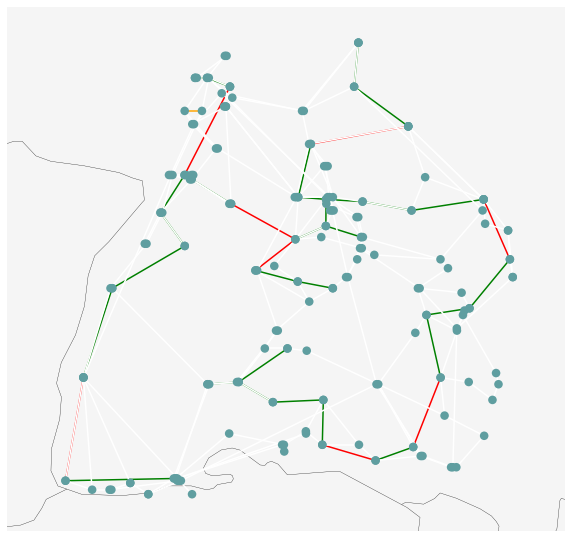

In [11]:
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(10, 10)
)

network.plot(ax=ax, margin=0.08, bus_sizes = 0.0005, color_geomap=True, 
             link_colors = link_colors, line_colors = line_colors)

In [12]:
network.lopf(pyomo=False, solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 4.33s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2022-08-08
Read LP format model from file C:\Users\HPELIT~1\AppData\Local\Temp\pypsa-problem-sd5ktcy9.lp
Reading time = 1.94 seconds
obj: 457711 rows, 185401 columns, 1299355 nonzeros
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 457711 rows, 185401 columns and 1299355 nonzeros
Model fingerprint: 0x11dacd17
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [1e+00, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 2e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 383630 rows and 95921 columns
Presolve time: 1.94s
Presolved: 74081 rows, 89480 columns, 667735 nonzeros

Ordering time: 2.17s

Barrier statistics:
 Dense cols : 75
 Free vars  : 32470
 AA' NZ     : 9.090e+05
 Factor NZ  : 5.953e+06 (roughly 110 M

('warning', 'infeasible or unbounded')

In [13]:
index_list = []
capital_costs = []
marginal_costs = []
efficiency = []
p_nom_opt_sum = []
capacity = []

for all_carr in list(techno_econ_data.index):
    if all_carr in list(network.generators['carrier'].unique()):
        index_list.append(all_carr)
        capital_costs.append(techno_econ_data.at['{}'.format(all_carr), 'capital_costs']) 
        marginal_costs.append(techno_econ_data.at['{}'.format(all_carr), 'marginal_costs'])
        efficiency.append(techno_econ_data.at['{}'.format(all_carr), 'efficiency'])
        p_nom_opt_sum.append(round(network.generators[network.generators['carrier'] == '{}'.format(all_carr)]['p_nom_opt'].sum(),2))
        capacity.append((network.generators[network.generators['carrier'] == '{}'.format(all_carr)]['p_nom'].sum()))
        
df_p_nom_opt_tech_cost = pd.DataFrame(index=index_list)
df_p_nom_opt_tech_cost.index.names = ['gen_type']
df_p_nom_opt_tech_cost['capital_costs (Euro/MW)'] = capital_costs
df_p_nom_opt_tech_cost['marginal_costs (Euro/MWh)'] = marginal_costs
df_p_nom_opt_tech_cost['efficiency'] = efficiency
df_p_nom_opt_tech_cost['p_nom_opt_sum (MW)'] = p_nom_opt_sum
df_p_nom_opt_tech_cost['capacity (MW)'] = capacity

su_index_list = []
su_capital_costs = []
su_marginal_costs = []
su_efficiency = []
su_p_nom_opt_sum = []
su_capacity = []

for su_all_carr in list(techno_econ_data.index):
    if su_all_carr in list(network.storage_units['carrier'].unique()):
        su_index_list.append(su_all_carr)
        su_capital_costs.append(techno_econ_data.at['{}'.format(su_all_carr), 'capital_costs']) 
        su_marginal_costs.append(techno_econ_data.at['{}'.format(su_all_carr), 'marginal_costs'])
        su_efficiency.append(techno_econ_data.at['{}'.format(su_all_carr), 'efficiency'])
        su_p_nom_opt_sum.append(round(network.storage_units[network.storage_units['carrier'] == '{}'.format(su_all_carr)]['p_nom_opt'].sum(),2))
        su_capacity.append((network.storage_units[network.storage_units['carrier'] == '{}'.format(su_all_carr)]['p_nom'].sum()))
        
df_su_p_nom_opt_tech_cost = pd.DataFrame(index=su_index_list)
df_su_p_nom_opt_tech_cost.index.names = ['gen_type']
df_su_p_nom_opt_tech_cost['capital_costs (Euro/MW)'] = su_capital_costs
df_su_p_nom_opt_tech_cost['marginal_costs (Euro/MWh)'] = su_marginal_costs
df_su_p_nom_opt_tech_cost['efficiency'] = su_efficiency
df_su_p_nom_opt_tech_cost['p_nom_opt_sum (MW)'] = su_p_nom_opt_sum
df_su_p_nom_opt_tech_cost['capacity (MW)'] = su_capacity

df_gen_p_nom_opt_costs = pd.concat([df_p_nom_opt_tech_cost, df_su_p_nom_opt_tech_cost])
df_gen_p_nom_opt_costs.sort_values(by='p_nom_opt_sum (MW)', ascending=False)

,capital_costs (Euro/MW),marginal_costs (Euro/MWh),efficiency,p_nom_opt_sum (MW),capacity (MW)
gen_type,,,,,
Run_of_River,12464.18,0.00,0.90,0.0,612.0
Biomass,11586.79,14.89,0.47,0.0,264.8
Solar,1937.87,0.00,1.00,0.0,150.0
Wind_Onshore,4003.58,0.00,1.00,0.0,261.5
CCGT,4126.16,38.86,0.58,0.0,1194.9
Coal,14582.36,28.20,0.33,0.0,5961.7
Oil,1577.95,148.86,0.35,0.0,701.8
Pumped_Storage,7389.38,0.00,0.75,0.0,1875.0


In [14]:
electro_p_nom_opt = []

for electro_loc in list(network.links.index):
    if 'Electrolysis' in '{}'.format(electro_loc).split('_'):
        electro_p_nom_opt.append(network.links.at['{}'.format(electro_loc), 'p_nom_opt'])

In [15]:
df_h2_p_nom_opt_loads = pd.DataFrame(index=h2_buses)
df_h2_p_nom_opt_loads.index.names = ['H2_bus']
df_h2_p_nom_opt_loads['load (MW)'] = list(df_h2_buses_load['h2_load'])
df_h2_p_nom_opt_loads['electrolysis p_nom_opt (MW)'] = electro_p_nom_opt
df_h2_p_nom_opt_loads.sort_values(by='load (MW)', ascending=False)

,load (MW),electrolysis p_nom_opt (MW)
H2_bus,,
KarlsruheWest_110kV_H2_Bus,831260.740,0.0
GKMannheim_110kV_H2_Bus,282548.792,0.0
Weier_110kV_H2_Bus,153927.858,0.0
Kuppenheim_110kV_H2_Bus,134307.538,0.0
Schmiechen_110kV_H2_Bus,127692.740,0.0
Ravensburg_110kV_H2_Bus,126944.780,0.0
Ludwigsburg_110kV_H2_Bus,119218.600,0.0
Stuttgart_110kV_H2_Bus,106583.600,0.0
Grossgartach_110kV_H2_Bus,100517.520,0.0


In [16]:
df_h2_p_nom_opt_loads['electrolysis p_nom_opt (MW)'].sum()

0.0

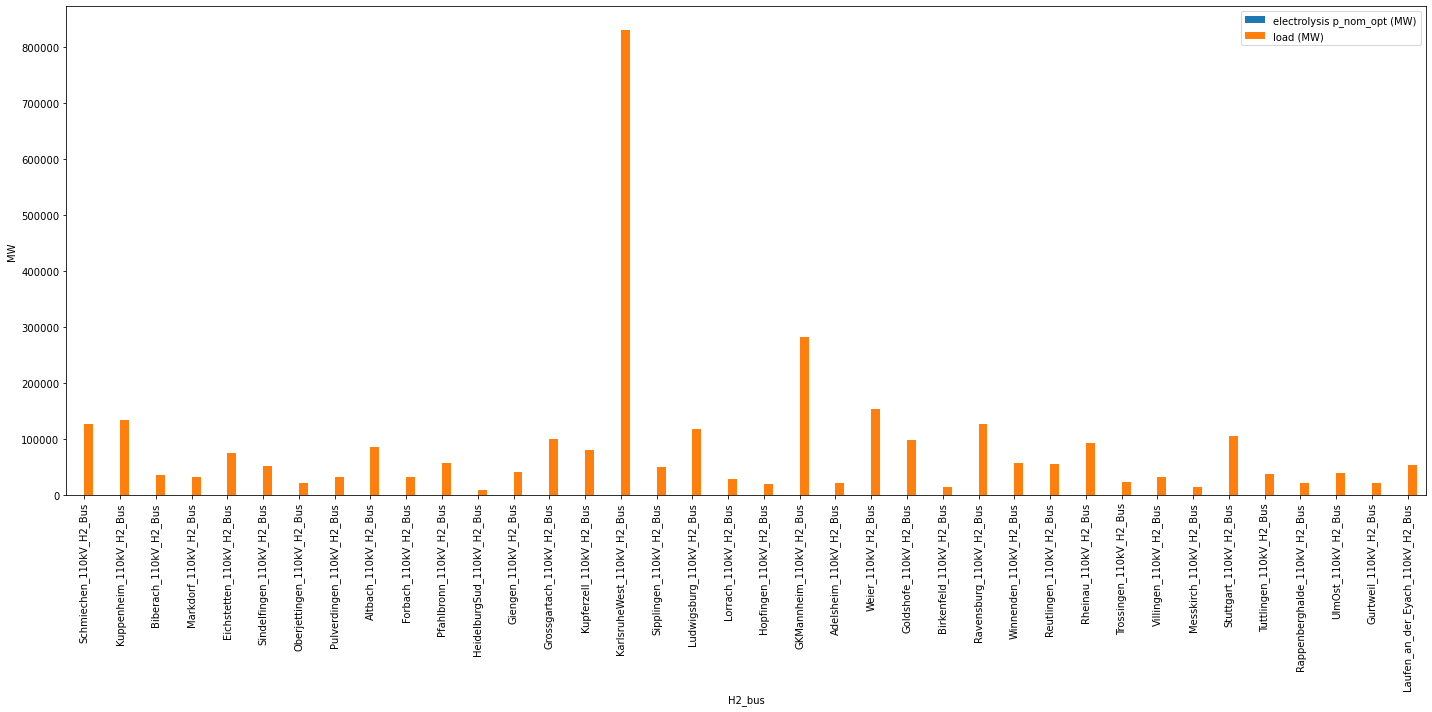

In [17]:
df_h2_p_nom_opt_loads.reset_index(inplace=True)
df_h2_p_nom_opt_loads.plot(ylabel="MW", x="H2_bus", y=["electrolysis p_nom_opt (MW)", "load (MW)"], 
                           kind="bar", figsize=(20,10))
plt.tight_layout()

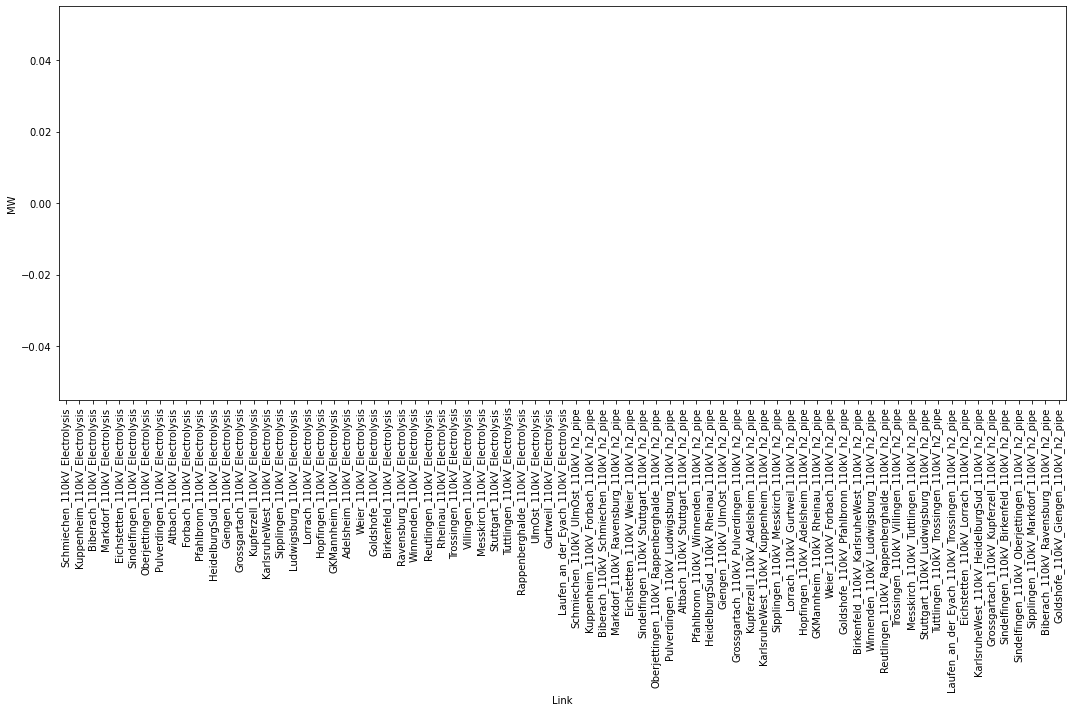

In [18]:
network.links.p_nom_opt.plot.bar(ylabel='MW', figsize=(15,10))
plt.tight_layout()

In [19]:
df_h2_e_nom_opt_loads = pd.DataFrame(index=h2_stores)
df_h2_e_nom_opt_loads.index.names = ['H2_stores']
df_h2_e_nom_opt_loads['load (MW)'] = list(df_h2_buses_load['h2_load'])
df_h2_e_nom_opt_loads['H2 stores e_nom_opt (MWh)'] = list(network.stores.e_nom_opt)
df_h2_e_nom_opt_loads.sort_values(by='load (MW)', ascending=False)

,load (MW),H2 stores e_nom_opt (MWh)
H2_stores,,
KarlsruheWest_110kV_H2_Store,831260.740,0.0
GKMannheim_110kV_H2_Store,282548.792,0.0
Weier_110kV_H2_Store,153927.858,0.0
Kuppenheim_110kV_H2_Store,134307.538,0.0
Schmiechen_110kV_H2_Store,127692.740,0.0
Ravensburg_110kV_H2_Store,126944.780,0.0
Ludwigsburg_110kV_H2_Store,119218.600,0.0
Stuttgart_110kV_H2_Store,106583.600,0.0
Grossgartach_110kV_H2_Store,100517.520,0.0


In [20]:
str_unit_carr = list(np.unique(list(network.stores.carrier)))

df_stor_p_nom_opt = pd.DataFrame(index=str_unit_carr)

str_p_nom_opt_list = []
str_p_nom_list = []

for carr_count_z in range(len(str_unit_carr)):
    p_nom_opt_sum_z = network.stores[network.stores['carrier'] == '{}'.format(str_unit_carr[carr_count_z])]['e_nom_opt'].sum()
    p_nom_sum_z = network.stores[network.stores['carrier'] == '{}'.format(str_unit_carr[carr_count_z])]['e_nom'].sum()
    str_p_nom_opt_list.append(round(p_nom_opt_sum_z,2))
    str_p_nom_list.append(round(p_nom_sum_z,2))
    

df_stor_p_nom_opt['capacity e_nom_sum (MWh)'] = str_p_nom_list
df_stor_p_nom_opt['e_nom_opt_sum (MWh)'] = str_p_nom_opt_list  

df_stor_p_nom_opt        

,capacity e_nom_sum (MWh),e_nom_opt_sum (MWh)
H2,0.0,0.0


In [21]:
h2_pipe_p_nom_opt = []

for h2_pipe_loc in list(network.links.index):
    if 'pipe' in '{}'.format(h2_pipe_loc).split('_'):
        h2_pipe_p_nom_opt.append(network.links.at['{}'.format(h2_pipe_loc), 'p_nom_opt'])

In [22]:
df_h2_p_nom_opt_pipe = pd.DataFrame(index=list(df_h2_pipes.index))
df_h2_p_nom_opt_pipe.index.names = ['H2_pipes']
df_h2_p_nom_opt_pipe['H2 pipes p_nom_opt (MW)'] = h2_pipe_p_nom_opt
df_h2_p_nom_opt_pipe

,H2 pipes p_nom_opt (MW)
H2_pipes,
Schmiechen_110kV_UlmOst_110kV_h2_pipe,0.0
Kuppenheim_110kV_Forbach_110kV_h2_pipe,0.0
Biberach_110kV_Schmiechen_110kV_h2_pipe,0.0
Markdorf_110kV_Ravensburg_110kV_h2_pipe,0.0
Eichstetten_110kV_Weier_110kV_h2_pipe,0.0
Sindelfingen_110kV_Stuttgart_110kV_h2_pipe,0.0
Oberjettingen_110kV_Rappenberghalde_110kV_h2_pipe,0.0
Pulverdingen_110kV_Ludwigsburg_110kV_h2_pipe,0.0
Altbach_110kV_Stuttgart_110kV_h2_pipe,0.0


In [23]:
df_h2_p_nom_opt_pipe['H2 pipes p_nom_opt (MW)'].sum()

0.0